# Temporal Gaussian process

---

In [2]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `/home/synd/Wouter/Onderzoek/Projecten/tue/tgp-hopt-ar/hopt-bar`
Precompiling project...
   1843.3 ms  ? DomainSets
   2479.0 ms  ? DomainIntegrals
   4126.3 ms  ? BayesBase
   2970.5 ms  ? BayesBase → FastCholeskyExt
   3048.5 ms  ? ExponentialFamily
   2999.0 ms  ? ReactiveMP
   3302.8 ms  ? RxInfer


In [3]:
using Revise
using DifferentialEquations
using Distributions
using LinearAlgebra
using JLD2
using RxInfer
using Optim
using GaussianProcesses
using Plots; 
default(label="", linewidth=3, margin=15Plots.pt);

includet("MAR.jl"); using .MAR

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Module BayesBase with build ID ffffffff-ffff-ffff-0000-1386c274cbfa is missing from the cache.
│ This may mean BayesBase [b4ee3484-f114-42fe-b91c-797d54a0c67e] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2541
┌ Warning: Module BayesBase with build ID ffffffff-ffff-ffff-0000-1386c274cbfa is missing from the cache.
│ This may mean BayesBase [b4ee3484-f114-42fe-b91c-797d54a0c67e] does not support precompilation but is

## Data simulation

In [111]:
# Time parameters
Δt = 0.001
len_time = 1000
tspan = (0.0, Δt*(len_time-1))

# True hyperparameters
λ  = 1.2
σ2 = 0.5

# Initial condition
u_0 = 1.0

# SDE functions
f(u,p,t) = -λ*u
g(u,p,t) = σ2
problem = SDEProblem(f,g,u_0, tspan)
solution = solve(problem, EM(), dt=Δt)

retcode: Success
Interpolation: 1st order linear
t: 1000-element Vector{Float64}:
 0.0
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009000000000000001
 ⋮
 0.9910000000000008
 0.9920000000000008
 0.9930000000000008
 0.9940000000000008
 0.9950000000000008
 0.9960000000000008
 0.9970000000000008
 0.9980000000000008
 0.999
u: 1000-element Vector{Float64}:
 1.0
 0.9844826725029802
 0.9729474074961725
 0.9779966892140946
 0.962780542979474
 0.9526843460771288
 0.9410436454032324
 0.9517414902252087
 0.9353065385648666
 0.961110816004977
 ⋮
 0.3136274769014048
 0.3174640422010247
 0.3301310654959232
 0.34702217972657645
 0.33818949538844834
 0.33516940272722995
 0.3430820698613216
 0.33421672160458576
 0.3642290377876525

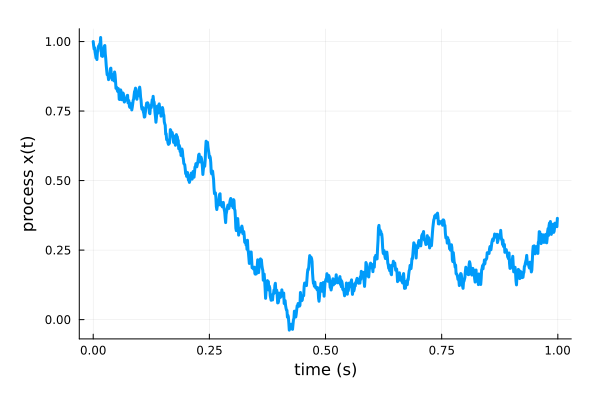

In [112]:
tsteps = solution.t
signal = solution.u
plot(tsteps, signal, label="", xlabel="time (s)", ylabel="process x(t)")

## Temporal Gaussian process

### Matern-1/2 GP in state-space form
Suppose a function $x(t)$ follows a zero-mean Gaussian Process

$$\begin{aligned}
x(t) \sim \mathcal{GP}(0, k(t,t')) \, .
\end{aligned}$$

The GP can be written as the following differential equation ([Hartikainen, 2013)](https://aaltodoc.aalto.fi/bitstream/handle/123456789/7579/isbn9789526049847.pdf?sequence=1&isAllowed=y)):

$$\begin{align}
\dot{x} = F x + L w \, ,
\end{align}$$

with $x$ being states, $F$ a state transition matrix and $w$ a white noise process. The Matern GP has a stationary covariance function, defined as:

$$\begin{aligned}
k(\tau) = \sigma^2 \frac{2^{1-\nu}}{\Gamma(\nu)} \left(\frac{\sqrt{2\nu}\tau}{l} \right)^\nu K_\nu\left(\frac{\sqrt{2\nu}\tau}{l} \right)
\end{aligned}$$

where $\sigma^2$ is a scale hyperparameter, $l$ a characteristic length-scale, $\nu$ the smoothness hyperparameter, and $K_\nu(.)$ is a modified Bessel function of the second kind. 

Matern-1/2 refers to $\nu=1/2$. The matrices for the state space model are computed as follows:

$$\begin{aligned}
\mathbf{F} = -\lambda,\quad \quad \mathbf{L} = 1, \quad \quad \mathbf{P}_\infty = \sigma^2  ,\quad \quad  Q_c = 2\lambda\sigma^2
\end{aligned}$$ 

where $\lambda = \frac{\sqrt{3}}{l} $.


In [153]:
# Define temporal Gaussian process
kernel = Mat12Iso(λ, σ2)
kmean  = MeanZero()

gp = GP(tsteps, signal, kmean, kernel)
optimize!(gp, domean=false, kern=true)

ppgp_m, ppgp_s = predict_y(gp, tsteps)

MAE_GP = mean(abs.(ppgp_m[M+1:end] .- signal[M+1:end]))

PosDefException(2)


1.0028253348333177e-12

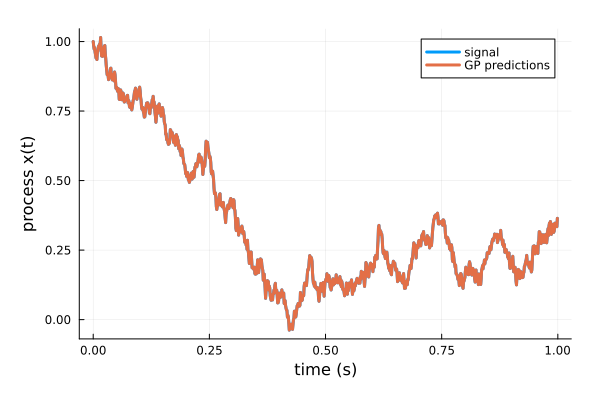

In [155]:
plot(tsteps, signal, label="signal", xlabel="time (s)", ylabel="process x(t)")
plot!(tsteps, ppgp_m, ribbon=ppgp_s, label="GP predictions")

## Bayesian auto-regression



In [156]:
# Model parameters
M = 1
Dy = 1
Dx = Dy*M
len_horizon = 3

# Prior parameters
ν0 = 100
Ω0 = 1e-1diagm(ones(Dy))
Λ0 = 1e-3*diagm(ones(Dx))
M0 = zeros(Dx,Dy)

ARmodel = MARModel(M0,Λ0,Ω0,ν0, Dy=Dy, delay=M, time_horizon=len_horizon)

Ms = zeros(Dx,Dy,len_time)
Λs = zeros(Dx,Dx,len_time)
Ωs = zeros(Dy,Dy,len_time)
νs = zeros(len_time)

ppar_m = zeros(Dy,len_time)
ppar_s = repeat(diagm(ones(Dy)), outer=[1, 1, len_time])

for (k,t) in enumerate(tsteps)

    x_k = ARmodel.ybuffer[:]
    η,μ,Ψ = posterior_predictive(ARmodel, x_k)
    ppar_m[:,k] = μ
    ppar_s[:,:,k] = inv(Ψ) * η/(η - 2)

    # Update parameters
    MAR.update!(ARmodel, [signal[k]])

    # Store
    Ms[:,:,k] = ARmodel.M
    Λs[:,:,k] = ARmodel.Λ
    Ωs[:,:,k] = ARmodel.Ω
    νs[k]     = ARmodel.ν

end

MAE_AR = mean(abs.(ppar_m[M+1:end] .- signal[M+1:end]))

0.013411286583452312

In [157]:
println("MAE GP = $MAE_GP")
println("MAE AR = $MAE_AR")

MAE GP = 1.0028253348333177e-12
MAE AR = 0.013411286583452312


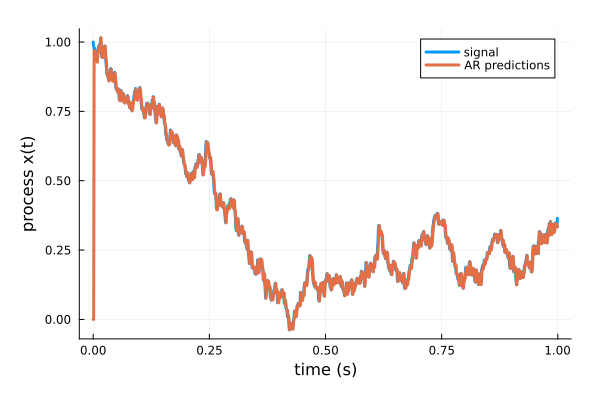

In [158]:
plot(tsteps, signal, label="signal", xlabel="time (s)", ylabel="process x(t)")
plot!(tsteps, ppar_m', ribbon=ppar_s[:]', label="AR predictions")

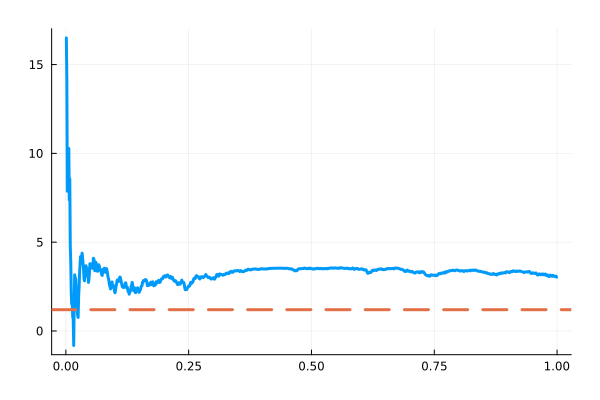

In [149]:
invert_λ(θ) = (1 .- θ)./Δt

plot(tsteps[M+1:end], invert_λ.(Ms[:,:,M+1:end][:]))
hline!([λ], linestyle=:dash)

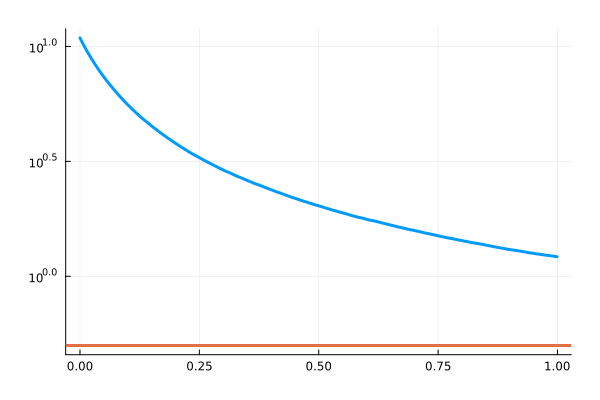

In [150]:
σ_hat = 1 ./νs.*Ωs[:] ./ Δt

plot(yscale=:log)
plot!(tsteps, σ_hat)
hline!([σ2])

In [151]:
# Kernel hyperparameter priors
α_l = 5.
β_l = 0.1
α_γ = 5.
β_γ = 0.1

prior_l = GammaShapeRate(α_l, β_l)
prior_γ = GammaShapeRate(α_γ, β_γ)

[mode(GammaShapeRate(α_l, β_l)) mean(GammaShapeRate(α_l, β_l))  var(GammaShapeRate(α_l, β_l))]

1×3 Matrix{Float64}:
 40.0  50.0  500.0

In [15]:
function J(hparams::AbstractVector)

    λ = sqrt(3)/hparams[1]
    A = [inv(M)*(K-true_h_a*diagm(An))              inv(M);
         zeros(Dh,Dh)                   -λ*diagm(ones(Dh))]*Δt + diagm(ones(Dx))
        
    Q = analyticQ(inv(M), λ, hparams[2], Δt=Δt)
        
    m0 = [τ_0; zeros(3)]
    S0 = diagm([1e-3ones(3); hparams[2]^2*ones(3)])

    results = infer(
        model       = SSM(A=A, B=B, C=C, Q=Q, R=R, m0=m0, S0=S0, T=T),
        data        = (y = output_, u = inputs_),
        options     = (limit_stack_depth = 100,),
        free_energy = true,
    )

    return results.free_energy[end] - logpdf(prior_l, hparams[1]) -logpdf(prior_γ, hparams[2])
end

J (generic function with 1 method)

In [16]:
# ops = Optim.Options(f_tol=1e-3, g_tol=1e-3, time_limit=60, show_every=1)
# res = optimize(J, 1e0, 1e6, [10., 10.], Fminbox(LBFGS()), ops; autodiff=:forward)
# l_star, γ_star = Optim.minimizer(res)

l_star = 1423.21
γ_star = 20.345

20.345

In [17]:
λ_star = sqrt(3)/l_star
A = exp([inv(M)*(K - true_h_a*diagm(An))                  inv(M);
         zeros(Dh,Dh)                  -λ_star*diagm(ones(Dh))]*Δt)
Q = analyticQ(inv(M), λ_star, γ_star, Δt=Δt)

m0 = [τ_0; zeros(Dh)]
S0 = diagm([ones(Dt); γ_star^2*ones(Dh)])

results = infer(
        model       = SSM(A=A, B=B, C=C, Q=Q, R=R, m0=m0, S0=S0, T=T),
        data        = (y = output_, u = inputs_),
        options     = (limit_stack_depth = 100,),
        free_energy = true,
    )

Inference results:
  Posteriors       | available for (x_0, x)
  Free Energy:     | Real[-5591.79]


In [18]:
H = ForwardDiff.jacobian(x -> ForwardDiff.gradient(J, x), [l_star, γ_star])
post_S = inv(Hermitian((H + H')/2))

2×2 Hermitian{Float64, Matrix{Float64}}:
 -2796.89   -174.805
  -174.805    -3.50829

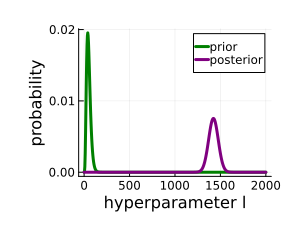

In [19]:
lr = range(1e-3, stop=2e3, length=500)
post_l = NormalMeanVariance(l_star, abs(post_S[1,1]))

p401 = plot(legend=:topright, ylabel="probability", xlabel="hyperparameter l", size=(300,240), yticks=[0., 0.01, 0.02])
plot!(lr, pdf.(prior_l, lr), color="green", label="prior")
plot!(lr, pdf.(post_l, lr), color="purple", label="posterior")

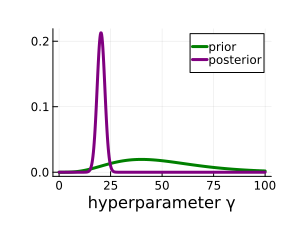

In [20]:
γr = range(1e-2, stop=1e2, length=500)
post_γ = NormalMeanVariance(γ_star, abs(post_S[2,2]))

p402 = plot(legend=:topright, ylabel="", xlabel="hyperparameter γ", size=(300,240), yticks=[0., 0.1, 0.2])
plot!(γr, pdf.(prior_γ, γr), color="green", label="prior")
plot!(γr, pdf.(post_γ, γr), color="purple", label="posterior")

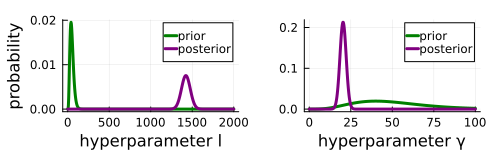

In [21]:
plot(p401,p402, layout=(1,2), size=(500,150), margin=3.0Plots.mm)

In [22]:
savefig("figures/hparams-estimated.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/sioux/sysid-thermal/CCTA2024-BIDconvection/experiment-simulated/figures/hparams-estimated.png"